In [70]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
df = pd.read_csv('../data/processed_MOFs.csv')
df.drop(columns='MOFname', inplace=True)
df

,CO2_uptake_P0.15bar_T298K [mmol/g],volume [A^3],weight [u],surface_area [m^2/g],void_fraction,void_volume [cm^3/g],largest_free_sphere_diameter [A],largest_included_sphere_diameter [A],metal_linker
0,5.955197,2473.186302,1493.011840,613.30,0.14835,0.1480,4.61370,4.61370,9
1,5.715251,2419.885159,1444.796800,0.00,0.16099,0.1624,4.10210,4.10055,9
2,5.524486,2514.627698,1504.683120,0.00,0.17980,0.1810,4.24711,4.24603,9
3,5.517258,2128.612920,1424.810240,0.00,0.10245,0.0922,4.11419,3.63925,9
4,5.451593,2415.251225,1436.905520,1347.04,0.15634,0.1583,4.37077,4.16451,9
...,...,...,...,...,...,...,...,...,...
324421,0.000000,949.067112,753.787520,0.00,0.00000,0.0000,3.15041,2.95451,2
324422,0.000000,1202.182553,1042.538240,0.00,0.00000,0.0000,3.20407,3.17435,3
324423,0.000000,1188.302573,1001.700216,0.00,0.00000,0.0000,3.36153,3.36153,3
324424,0.000000,1506.660363,1493.296496,0.00,0.01108,0.0000,3.72847,3.11676,10


In [ ]:
X = df.copy()
Y = X.pop('CO2_uptake_P0.15bar_T298K [mmol/g]')

X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)


,volume [A^3],weight [u],surface_area [m^2/g],void_fraction,void_volume [cm^3/g],largest_free_sphere_diameter [A],largest_included_sphere_diameter [A],metal_linker
0,-0.465574,-0.340689,-1.326955,-1.314960,-0.868547,-1.318181,-1.291348,1.865115
1,-0.472079,-0.367889,-1.692744,-1.252422,-0.850063,-1.432033,-1.405475,1.865115
2,-0.460516,-0.334105,-1.692744,-1.159358,-0.826187,-1.399762,-1.373120,1.865115
3,-0.507627,-0.379164,-1.692744,-1.542055,-0.940175,-1.429342,-1.508071,1.865115
4,-0.472645,-0.372340,-0.889333,-1.275429,-0.855326,-1.372243,-1.391250,1.865115
...,...,...,...,...,...,...,...,...
324421,-0.651584,-0.757704,-1.692744,-2.048938,-1.058527,-1.643822,-1.660361,-0.552905
324422,-0.620692,-0.594813,-1.692744,-2.048938,-1.058527,-1.631881,-1.611467,-0.207473
324423,-0.622386,-0.617850,-1.692744,-2.048938,-1.058527,-1.596839,-1.569837,-0.207473
324424,-0.583533,-0.340529,-1.692744,-1.994119,-1.058527,-1.515181,-1.624276,2.210547


In [77]:
x_base = X_scaled.sample(frac=0.01, random_state=42)
y_base = Y.loc[x_base.index]

# Train and score baseline model
baseline = RandomForestRegressor()
baseline_score = cross_val_score(
    baseline, x_base, y_base, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 0.1956


In [33]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, Y)

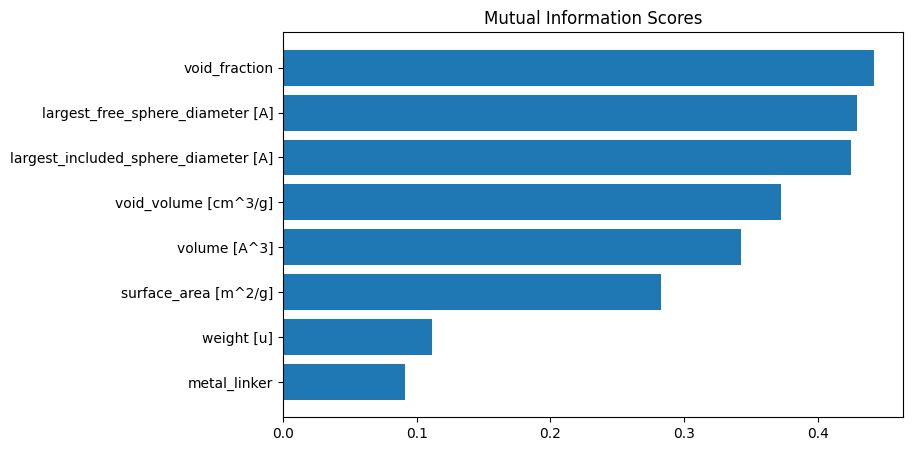

In [35]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [50]:
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-2.991451,1.026057,-1.126481,0.303278,0.263076,-0.010405,-0.169039,-0.023865
1,-3.197896,1.110292,-1.071438,0.401682,0.162403,-0.023385,-0.472495,-0.026398
2,-3.112622,1.115707,-1.080514,0.363179,0.149523,-0.020026,-0.532084,-0.027053
3,-3.406572,1.162356,-1.025056,0.464568,0.166305,-0.059619,-0.261826,0.050149
4,-2.881868,0.836404,-1.183193,0.206013,0.600803,0.018543,0.006115,0.007373


In [51]:
mi_scores = make_mi_scores(X_pca, Y)
mi_scores

PC1    0.414099
PC4    0.229131
PC3    0.199516
PC2    0.169909
PC6    0.091510
PC7    0.087593
PC8    0.062830
PC5    0.060869
Name: MI Scores, dtype: float64

In [ ]:
# use 4 components 
X_pca_4 = X_pca.iloc[:, :4]
X_pca_4

,PC1,PC2,PC3,PC4
0,-2.991451,1.026057,-1.126481,0.303278
1,-3.197896,1.110292,-1.071438,0.401682
2,-3.112622,1.115707,-1.080514,0.363179
3,-3.406572,1.162356,-1.025056,0.464568
4,-2.881868,0.836404,-1.183193,0.206013
...,...,...,...,...
324421,-3.555155,0.108648,1.172254,0.948572
324422,-3.538857,0.357793,0.898053,0.855663
324423,-3.512454,0.342392,0.883437,0.860401
324424,-3.792761,1.390762,-1.254343,0.511484


In [76]:
x = X_pca_4.sample(frac=0.01, random_state=42)
y = Y.loc[x.index]

# Train and score baseline model
baseline = RandomForestRegressor()
baseline_score = cross_val_score(
    baseline, x, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 0.2272
